# 第三课：图神经网络

图神经网络（Graph Neural Network, GNN）是深度神经网络（Deep Neural Network, DNN）在图数据上的泛化，它是非常强力的图特征提取工具。在本次实践课中，我们将讲解常见的图神经网络比如GCN和GAT，以及如何利用图神经网络来完成节点分类和图分类问题。

## 1. GCN

### 1.1 用矩阵形式实现GCN

首先我们来回顾一下GCN每一层的操作。给定图的邻接矩阵$A$和节点特征矩阵$X$，如果我们用$W$表示GCN层中的参数、$H$表示隐藏层的特征，那么一层GCN中的操作可以表达为$H=\text{ReLU}(AXW)$。

In [1]:
# 导入需要用到的工具包
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter
from sklearn.metrics import f1_score
import scipy.sparse as sp
import numpy as np

In [2]:
class GraphConvolution(nn.Module):
    """GCN层，参考https://github.com/tkipf/pygcn
    
    参数说明
    ----------
    in_features : 输入特征的维度
    out_features : 输出神经元的数量，也即类别的数量
    with_bias: 是否带有偏置项
    """

    def __init__(self, in_features, out_features, with_bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if with_bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self): 
        """初始化参数"""
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        """前向传播"""
        if x.data.is_sparse:
            support = torch.spmm(x, self.weight) # XW
        else:
            support = torch.mm(x, self.weight) # XW
        output = torch.spmm(adj, support) # AXW
        if self.bias is not None:
            return output + self.bias # AXW + b
        else:
            return output # AXW

In [3]:
class GCN(nn.Module):
    """ 2层GCN
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    dropout : dropout中的概率
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):

        super(GCN, self).__init__()

        self.nfeat = nfeat
        self.hidden_sizes = [nhid]
        self.nclass = nclass
        self.gc1 = GraphConvolution(nfeat, nhid, with_bias=with_bias)
        self.gc2 = GraphConvolution(nhid, nclass, with_bias=with_bias)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

    def initialize(self):
        """初始化每一层的参数"""
        self.gc1.reset_parameters()
        self.gc2.reset_parameters()

定义好GCN模型后，我们来简单看看怎么使用这个模型。我们继续以Cora数据集为例。

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_scipy_sparse_matrix
dataset = Planetoid(root='./data', name='Cora') # 将数据保存在data文件夹下
data = dataset[0]
adj = to_scipy_sparse_matrix(data.edge_index)
features = data.x
labels = data.y

In [5]:
adj

<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
	with 10556 stored elements in COOrdinate format>

In [6]:
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

接下来我们对邻接矩阵adj进行标准化（normalize）： 

$A \leftarrow A + I$

$\hat{A}= D^{-1/2}{A}D^{-1/2}$ 

In [7]:
def normalize_adj(mx):
    """标准化：A' = (D + I)^-1/2 * ( A + I ) * (D + I)^-1/2
    """
    mx = mx + sp.eye(mx.shape[0])
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1/2).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    mx = mx.dot(r_mat_inv)
    return mx

In [8]:
adj_norm = normalize_adj(adj)
adj_norm

<2708x2708 sparse matrix of type '<class 'numpy.float64'>'
	with 13264 stored elements in Compressed Sparse Row format>

In [9]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """将scipy.sparse形式的稀疏矩阵变成torch里的sparse tensor"""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    sparserow=torch.LongTensor(sparse_mx.row).unsqueeze(1)
    sparsecol=torch.LongTensor(sparse_mx.col).unsqueeze(1)
    sparseconcat=torch.cat((sparserow, sparsecol),1)
    sparsedata=torch.FloatTensor(sparse_mx.data)
    return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))

In [10]:
adj_norm = sparse_mx_to_torch_sparse_tensor(adj_norm)
adj_norm

tensor(indices=tensor([[   0,  633, 1862,  ..., 1473, 2706, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.2500, 0.2500, 0.2236,  ..., 0.2000, 0.2000, 0.2000]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)

In [11]:
nclass = labels.max().item()+1
model = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
output = model(features, adj_norm)
print(output.shape)
print(output)

torch.Size([2708, 7])
tensor([[-2.0752, -2.3191, -2.0057,  ..., -2.0551, -1.2794, -2.2606],
        [-2.2196, -2.2833, -1.9542,  ..., -2.6939, -1.0202, -2.2464],
        [-2.4039, -1.8827, -2.1646,  ..., -2.4674, -1.2409, -2.2958],
        ...,
        [-2.4754, -1.8965, -1.7704,  ..., -2.0333, -1.4974, -2.0669],
        [-2.1612, -2.2552, -2.2599,  ..., -1.8761, -1.3045, -2.1174],
        [-2.1761, -2.2625, -2.3818,  ..., -1.7510, -1.3544, -2.1298]],
       grad_fn=<LogSoftmaxBackward>)


### 1.2 PyTorch Geometric实现GCN

在这个小节，我们通过PyG来实现GCN。PyG中GCN的实现与上面用矩阵乘法的实现主要有以下不同：

- *PyG中，对`edge_index`和`edge_weight`进行操作，而不是`torch.SparseTensor`。*


#### 1.2.1 直接调用PyG提供的接口

In [16]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    """ 2层GCN
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    dropout : dropout中的概率
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(nfeat, nhid, bias=with_bias)
        self.conv2 = GCNConv(nhid, nclass, bias=with_bias)
        self.dropout = dropout
        
    def reset_parameters(self):
        """初始化模型参数"""
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        """模型前向传播"""
        x, edge_index = data.x, data.edge_index # 取出x, edge_index
        x = F.relu(self.conv1(x, edge_index)) 
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [18]:
nclass = labels.max().item()+1
model = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
output = model(data)
print(output)
print(output.shape)

tensor([[-2.0794, -1.8769, -1.9576,  ..., -1.9885, -1.9202, -1.9861],
        [-2.1015, -1.8984, -1.9962,  ..., -1.9449, -2.0177, -1.9656],
        [-2.0151, -1.9079, -1.9787,  ..., -1.9499, -1.9824, -1.9685],
        ...,
        [-1.9406, -1.9482, -1.9035,  ..., -1.9936, -2.0105, -1.9388],
        [-1.9294, -1.9585, -1.9458,  ..., -1.9624, -2.0442, -1.9079],
        [-1.9216, -1.9546, -1.9636,  ..., -1.9528, -2.0283, -1.9018]],
       grad_fn=<LogSoftmaxBackward>)
torch.Size([2708, 7])


#### 1.2.2 详细讲解`GCNConv`内部结构

下面这部分代码来自PyG中的[gcn_conv.py](https://github.com/pyg-team/pytorch_geometric/blob/74245f3a680c1f6fd1944623e47d9e677b43e827/torch_geometric/nn/conv/gcn_conv.py#L68)，这里做了一些修改（删除了一些不重要的变量）来让它更简洁易懂。

In [ ]:
from torch_geometric.typing import Adj, OptTensor, PairTensor
import torch
from torch import Tensor
from torch.nn import Parameter
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
from torch_geometric.nn.inits import zeros
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm


class GCNConv(MessagePassing):

    def __init__(self, in_channels: int, out_channels: int, bias: bool = True, **kwargs):

        kwargs.setdefault('aggr', 'add') # 设置aggregation方式为求和（'add'）
        super(GCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)

    def forward(self, x, edge_index, edge_weight):
        """前向传播过程"""

        edge_index, edge_weight = gcn_norm(  
                edge_index, edge_weight, x.size(self.node_dim)) # 对图结构进行标准化
        x = self.lin(x) # XW
         
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None) # self.propagate()继承自MessagePassing这个类
        if self.bias is not None:
            out += self.bias
        return out

    def message(self, x_j, edge_weight):
        """定义如何传递信息：给节点特征乘上一个权重"""
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

#     def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
#         return matmul(adj_t, x, reduce=self.aggr)

这里有几个需要注意的地方：

1. `foward()`函数中需要使用`self.propagate()`在节点之间进行信息的传递。`self.propagate()`继承自`MessagePassing`这个类。它的输入是`edge_index`, `edge_weight` 还有节点特征`x`。
1. `self.propagate()`中调用了`message()`，`message()`函数具体定义了传递信息的过程：给节点特征乘上一个权重。
1. 如果同学们需要设计自己的GNN模型的话，通常是改变`forward()`和`message()`函数。

## 2. GAT

接下来，我们介绍Graph Attention Network（GAT）。GAT和GCN的主要区别是，GAT在聚合邻居节点的信息的时候利用了注意力机制来对其进行加权。 我们用$\alpha_{ij}$来表示节点i和节点j之间的注意力分数，那么

$\alpha_{ij} = {\bf a}[{\bf W}{\bf h}_i || {\bf W}{\bf h}_j]$， 其中$[{\bf W}{\bf h}_i || {\bf W}{\bf h}_j]$表示对节点i和节点j的隐藏层表示的拼接；${\bf a}$是一个网络层，用来将向量表示转换成注意力分数。

这些注意力分数之后会通过softmax层进行归一化，并且上面这个式子只是其中一个attention head，实践中我们会用多个attention head得到多个$\alpha_{ij}$。

In [20]:
from torch_geometric.nn import GATConv
class GAT(nn.Module):
    """ 2层GAT.
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    heads: 注意力机制中的head数量
    output_heads: 输出曾的head数量
    dropout : dropout中的概率
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, heads=8, output_heads=1, dropout=0.5, with_bias=True):

        super(GAT, self).__init__()

        self.conv1 = GATConv(
            nfeat,
            nhid,
            heads=heads,
            dropout=dropout,
            bias=with_bias)

        self.conv2 = GATConv(
            nhid * heads,
            nclass,
            heads=output_heads,
            concat=False,
            dropout=dropout,
            bias=with_bias)

        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def initialize(self):
        """初始化GAT的参数.
        """
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

In [26]:
gat = GAT(nfeat=features.shape[1],
      nhid=8, heads=8,
      nclass=nclass)
output = gat(data)
print(output)
print(output.shape)

tensor([[-2.0089, -1.9391, -1.7778,  ..., -2.0575, -1.9461, -2.0833],
        [-1.8300, -1.7169, -2.6667,  ..., -2.4140, -2.1355, -1.9037],
        [-2.1941, -1.9759, -1.8921,  ..., -1.9943, -2.0023, -1.8859],
        ...,
        [-1.3637, -2.7322, -1.4418,  ..., -1.8735, -2.4310, -2.0300],
        [-1.8673, -1.8732, -2.0127,  ..., -1.9601, -1.9506, -2.0963],
        [-1.9414, -1.7817, -2.1745,  ..., -1.9223, -1.9619, -1.9651]],
       grad_fn=<LogSoftmaxBackward>)
torch.Size([2708, 7])


关于`GATConv`的具体实现，参见[gat_conv.py](https://github.com/pyg-team/pytorch_geometric/blob/74245f3a680c1f6fd1944623e47d9e677b43e827/torch_geometric/nn/conv/gat_conv.py#L17)。学有余力的同学可以尝试理解下其中`forward()`和`message()`函数的实现。

简单来讲，
1. `GATConv`里的`forward()`函数实现了注意力分数（attention score），这个分数就是`alpha`变量，它是每个相连接的节点对的拼接后的特征通过一个线性层得到的。`alpha`之后会经过一个softmax层进行归一化。
2. `message()`函数中定义了节点特征是怎么和注意力分数`alpha` 结合起来的：先对`alpha`进行dropout，然后再将节点特征和`alpha`想乘。

## 3. 利用GCN完成节点分类任务

关于节点分类任务，其实我们在上一次课（图嵌入）的时候已经有了初步的接触：我们用DeepWalk对Cora数据集上的节点进行了分类。在这里，我们同样以Cora数据集为例，来展示如何进行节点分类。

In [66]:
def train(model, data, lr=0.01, weight_decay=5e-4, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    labels = data.y
    train_mask = data.train_mask
    best_loss_val = 100

    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output[train_mask], labels[train_mask]) # 用训练集中的节点来计算损失函数
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Epoch {}, training loss: {}'.format(i, loss.item()))

@torch.no_grad()
def test(model, data):
    """Evaluate GAT performance on test set.

    """
    model.eval()
    test_mask = data.test_mask
    labels = data.y 
    output = model(data) # 得到模型输出
    loss_test = F.nll_loss(output[test_mask], labels[test_mask])
    preds = output[test_mask].argmax(1) # 得到预测值
    acc_test = preds.eq(labels[test_mask]).cpu().numpy().mean() # 得到准确率
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    return preds, output, acc_test.item()

In [44]:
model = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
# 将模型放到gpu/cpu上，默认是cpu
device = 'cpu' # device ='cuda'
model = model.to(device)
data = data.to(device)
train(model, data, epochs=100)

Epoch 0, training loss: 1.9441615343093872
Epoch 10, training loss: 0.7765031456947327
Epoch 20, training loss: 0.21071229875087738
Epoch 30, training loss: 0.12184865027666092
Epoch 40, training loss: 0.06967499852180481
Epoch 50, training loss: 0.038351647555828094
Epoch 60, training loss: 0.04270881786942482
Epoch 70, training loss: 0.046000976115465164
Epoch 80, training loss: 0.03642742708325386
Epoch 90, training loss: 0.05175086855888367


In [67]:
preds, output, acc = test(model, data)

Test set results: loss= 0.6423 accuracy= 0.7960


接下来我们使用tsne对得到的输出进行降维并可视化。

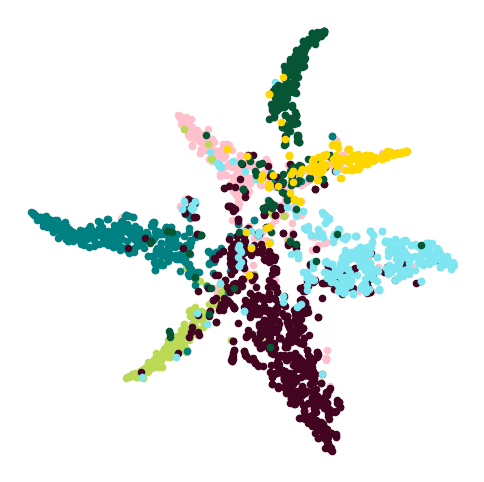

In [70]:
from bhtsne import tsne
import matplotlib.pyplot as plt
def plot_points(colors, embedding):
    z = tsne(embedding.astype('float64'))
    y = data.y.numpy()

    plt.figure(figsize=(6, 6))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors, output.cpu().numpy())

不难看出，得到的节点嵌入的分离度非常高，大家可以将这幅图和第二次实践课上的deepwalk得到的图进行对比。

## 4. 利用GCN完成图分类任务

在这一节中，我们将使用GCN完成图分类任务。

### 4.1 图分类数据集介绍

图分类任务中，每张图都对应了一个标签，节点是不对应标签的。本小节我们以ENZYMES数据集为例来介绍图分类任务。

In [80]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='./data/ENZYMES', name='ENZYMES', use_node_attr=True)

In [84]:
print(dataset)
print(len(dataset))

ENZYMES(600)
600


我们可以看到ENZYMES数据集一共有600张图。下面让我们取出第一张图来看看：

In [85]:
dataset[0]

Data(edge_index=[2, 168], x=[37, 21], y=[1])

这张图中共有168条边，37个节点，以及一个标签。这个标签代表的是这个图的标签，因为该数据集属于图分类数据集。

### 4.2 图分类任务实践

对于图分类任务，GCN需要以一张图为输入，并输出对应的预测标签。通常来讲，GCN会输出所有节点的表示（或嵌入），所以我们在设计图分类的GCN的时候，需要一个池化层（pooling）和一个预测层（线性层）。

In [118]:
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    """3层GCN+1池化层+1层线性层"""

    def __init__(self, nfeat, nhid, nclass, dropout=0.2):
        super(GCN, self).__init__()
        
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, nhid)
        self.gc3 = GCNConv(nhid, nhid)
        self.lin = nn.Linear(nhid, nclass) # 用于输出图的预测标签
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gc1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.gc2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training) 
        x = self.gc3(x, edge_index)
        x = global_mean_pool(x, batch=data.batch) # 池化层，对所有节点嵌入去一个均值作为图的潜入
        x = self.lin(x) 
        return F.log_softmax(x, dim=1)

In [109]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='./data/ENZYMES', name='ENZYMES', use_node_attr=True)
dataset = dataset.shuffle()

train_ratio = 0.8
test_ratio = 0.2
train_dataset = dataset[: int(train_ratio*len(dataset))]
test_dataset = dataset[-int(test_ratio*len(dataset)):]

# 创建训练集和测试集的dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [110]:
nfeat = dataset.num_node_features
nclass = dataset.num_classes
nhid = 64
device = 'cpu'
# device = ‘cuda’ # 如果有CUDA的话
model = GCN(nfeat, nhid, nclass).to(device)

In [111]:
def train(model, lr=0.001, epochs=1000):
    """训练给定网络"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        loss_all = 0
        for data in (train_loader): 
            data = data.to(device)
            optimizer.zero_grad()
            y_model = model(data)
            loss = F.nll_loss(y_model, data.y)
            loss.backward()
            loss_all += loss.item() * data.num_graphs
            optimizer.step()
        loss_train = loss_all / len(train_loader.dataset) 
        if epoch % 100 == 0:
            print('Epoch: {:03d}, Loss: {:.7f}'.format(epoch, loss_train))

@torch.no_grad()            
def test(model, loader):
    """测试给定网络"""
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)

        _, pred = model(data).max(dim=1)
        correct += float(pred.eq(data.y).sum().item())
    return correct / len(loader.dataset)

In [114]:
train(model, epochs=1000)

Epoch: 000, Loss: 0.7006554
Epoch: 100, Loss: 0.5054451
Epoch: 200, Loss: 0.3500624
Epoch: 300, Loss: 0.3367341
Epoch: 400, Loss: 0.2641970


In [115]:
test(model, test_loader)

0.6583333333333333